In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

In [7]:
df = pd.read_csv("merged-df.csv")
df

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_card_brand,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,...,Mastercard,Debit (Prepaid),YES,306,2022-07-01,2,55.0,2008-05-01,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,...,Mastercard,Credit,YES,438,2024-12-01,1,9100.0,2005-09-01,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,...,Mastercard,Debit,YES,256,2020-05-01,1,14802.0,2006-01-01,2008,No
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,...,Mastercard,Debit,NO,54,2024-10-01,2,37634.0,2004-05-01,2006,No
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,...,Visa,Debit,YES,120,2020-01-01,1,19113.0,2009-07-01,2014,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,...,Mastercard,Debit,YES,992,2020-02-01,1,26743.0,2019-03-01,2019,No
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,Unknown,Unknown,...,Mastercard,Debit,YES,91,2024-06-01,1,5141.0,2004-03-01,2012,No
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002,...,Mastercard,Debit,YES,908,2021-06-01,1,17686.0,2004-02-01,2007,No
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014,...,Visa,Debit,YES,762,2021-11-01,2,14036.0,2005-11-01,2010,No


In [29]:
dupe_counts = df['user_id'].value_counts().loc[lambda s: s > 1]
dupe_counts

user_id
1098    48479
909     43381
1963    42462
1776    41350
114     40286
        ...  
1016     2170
955      1997
1680     1983
1510     1845
1223      760
Name: count, Length: 1219, dtype: int64

In [31]:
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns")

# Ensure proper datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['card_acct_open_date'] = pd.to_datetime(df['card_acct_open_date'], errors='coerce')

Loaded dataset with 13,305,915 rows and 36 columns


## Feature 1: “Income Utilization Ratio” (income_utilization_ratio)

#### Business intuition:
Measures how much of a customer’s monthly income is being transacted.
High ratios may indicate financially strained customers (spending a large portion of their income); low ratios suggest savers or underutilized account holders.

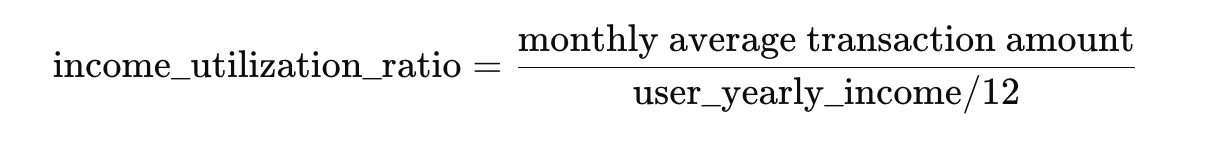

	​


In [32]:
monthly_txn = df.groupby(['user_id', df['date'].dt.to_period('M')])['amount'].sum().reset_index()
user_monthly_avg = monthly_txn.groupby('user_id')['amount'].mean().rename('avg_monthly_spend')

income_util = (
    user_monthly_avg.to_frame()
    .join(df[['user_id', 'user_yearly_income']].drop_duplicates().set_index('user_id'), how='left')
)
income_util['income_utilization_ratio'] = income_util.apply(
    lambda r: 0 if pd.isna(r['user_yearly_income']) or r['user_yearly_income'] == 0 
    else (r['avg_monthly_spend'] / (r['user_yearly_income'] / 12)), axis=1
)
income_util['income_utilization_ratio'] = income_util['income_utilization_ratio'].clip(0, 5)  # cap extreme outliers


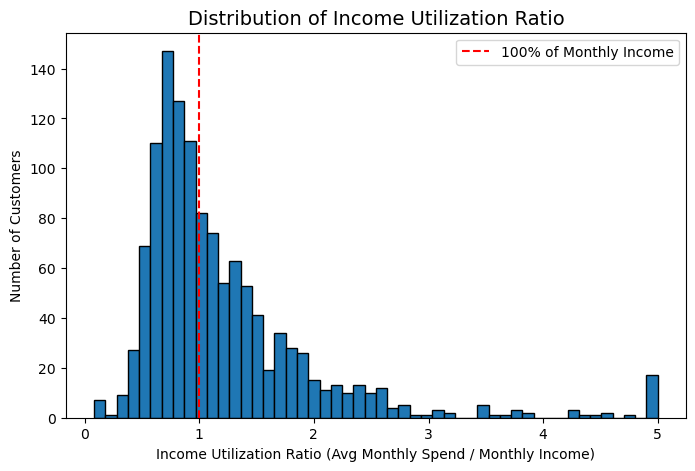

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(income_util['income_utilization_ratio'], bins=50, edgecolor='black')
plt.title("Distribution of Income Utilization Ratio", fontsize=14)
plt.xlabel("Income Utilization Ratio (Avg Monthly Spend / Monthly Income)")
plt.ylabel("Number of Customers")
plt.axvline(1, color='r', linestyle='--', label='100% of Monthly Income')
plt.legend()
plt.show()


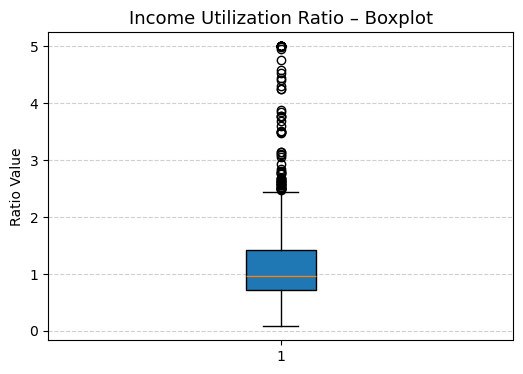

In [37]:
plt.figure(figsize=(6,4))
plt.boxplot(income_util['income_utilization_ratio'], vert=True, patch_artist=True)
plt.title("Income Utilization Ratio – Boxplot", fontsize=13)
plt.ylabel("Ratio Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [45]:
dupe_counts = df['user_id'].value_counts().loc[lambda s: s > 1]
dupe_counts
df['user_id'].nunique()

1219

In [41]:
income_util

,avg_monthly_spend,user_yearly_income,income_utilization_ratio
user_id,,,
0,5303.387034,59613.0,1.067563
1,2849.045508,45360.0,0.753716
2,2470.629407,27447.0,1.080175
3,2378.690339,27943.0,1.021518
4,5048.494576,76431.0,0.792636
...,...,...,...
1994,4019.745514,78180.0,0.616999
1995,3530.723559,39206.0,1.080668
1996,2914.752627,44768.0,0.781295


### Feature 2: “Credit Utilization Ratio” (credit_utilization_ratio)

Business intuition:
Shows how much of their available credit limit the customer actually uses.
Useful for differentiating high-risk spenders (those near their limit) vs conservative credit users.

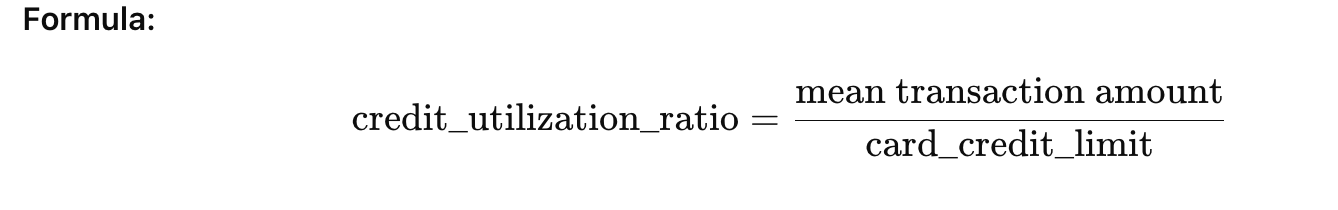

In [49]:
credit_util = (
    df.groupby('user_id')['amount'].mean().rename('avg_txn_amount')
    .to_frame()
    .join(df[['user_id', 'card_credit_limit']].drop_duplicates().set_index('user_id'), how='left')
)
credit_util['credit_utilization_ratio'] = credit_util.apply(
    lambda r: 0 if pd.isna(r['card_credit_limit']) or r['card_credit_limit'] == 0 
    else r['avg_txn_amount'] / r['card_credit_limit'], axis=1
)
credit_util['credit_utilization_ratio'] = credit_util['credit_utilization_ratio'].clip(0, 1)


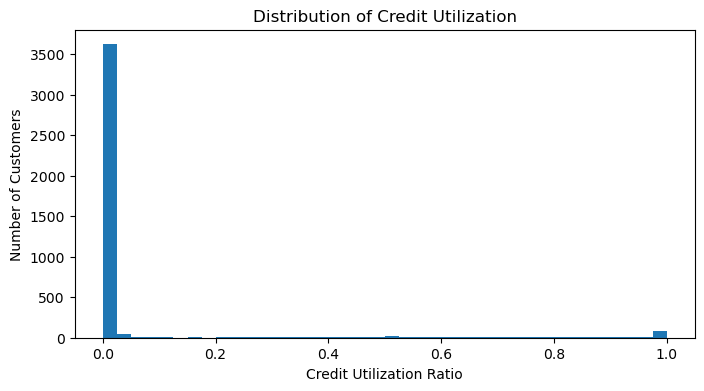

In [50]:
# assumes you’ve already built credit_util with 'credit_utilization_ratio'
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(credit_util['credit_utilization_ratio'].dropna(), bins=40)
plt.xlabel('Credit Utilization Ratio')
plt.ylabel('Number of Customers')
plt.title('Distribution of Credit Utilization')
plt.show()


<Figure size 900x400 with 0 Axes>

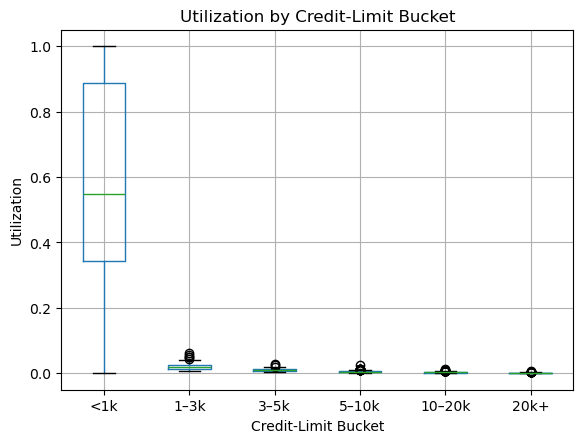

In [19]:
import numpy as np

bins = [0, 1000, 3000, 5000, 10000, 20000, np.inf]
labels = ['<1k','1–3k','3–5k','5–10k','10–20k','20k+']
tmp = credit_util.copy()
tmp['limit_bucket'] = pd.cut(tmp['card_credit_limit'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(9,4))
tmp.boxplot(column='credit_utilization_ratio', by='limit_bucket')
plt.suptitle('')
plt.title('Utilization by Credit-Limit Bucket')
plt.xlabel('Credit-Limit Bucket')
plt.ylabel('Utilization')
plt.show()


In [65]:
credit_util_user = (
    credit_util
      .groupby(level=0)['credit_utilization_ratio']
      .agg(
          credit_util_mean='mean',    
          credit_util_max='max',      
          credit_util_median='median'
      )
)
credit_util_user

,credit_util_mean,credit_util_max,credit_util_median
user_id,,,
0,0.002166,0.002779,0.002166
1,0.002504,0.003062,0.002607
2,0.002959,0.003712,0.003052
3,0.515529,0.754405,0.652125
4,0.002151,0.004090,0.001745
...,...,...,...
1994,0.253675,0.756810,0.002207
1995,0.005342,0.008777,0.004737
1996,0.004088,0.004685,0.004088


### Feature 3: “Card Age in Years” (card_age_years)

Business intuition:
Indicates card tenure — mature cardholders often have more stable behavior, higher trust, and lower churn risk.
Useful for distinguishing newly onboarded vs long-standing customers in PCA clusters.

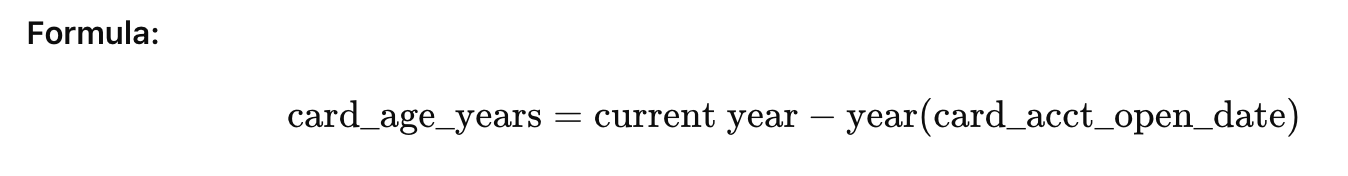

In [55]:
today_year = datetime.now().year
card_age = df[['user_id', 'card_acct_open_date']].drop_duplicates().set_index('user_id')
card_age['card_age_years'] = (today_year - card_age['card_acct_open_date'].dt.year).clip(lower=0)

# Merge new features together
new_features = (
    income_util[['income_utilization_ratio']]
    .join(credit_util[['credit_utilization_ratio']], how='outer')
    .join(card_age[['card_age_years']], how='outer'))

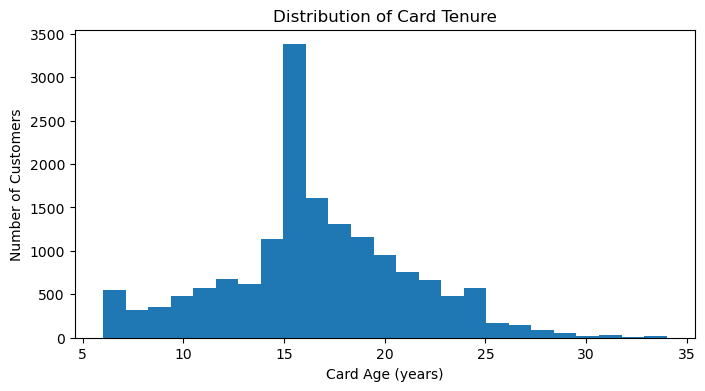

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(new_features['card_age_years'].dropna(), bins=25)
plt.xlabel('Card Age (years)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Card Tenure')
plt.show()

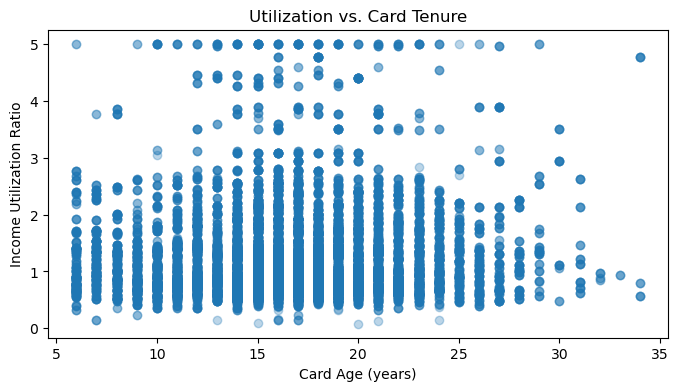

In [26]:
plt.figure(figsize=(8,4))
plt.scatter(new_features['card_age_years'], new_features['income_utilization_ratio'], alpha=0.3)
plt.xlabel('Card Age (years)')
plt.ylabel('Income Utilization Ratio')
plt.title('Utilization vs. Card Tenure')
plt.show()

In [67]:
card_age_user = (
    card_age
      .groupby(level=0)['card_age_years']
      .agg(
          oldest_card_age_years='max',   # longest history
          avg_card_age_years='mean'      # overall maturity
      )
)
card_age_user

,oldest_card_age_years,avg_card_age_years
user_id,,
0,18,16.000000
1,23,18.000000
2,20,15.800000
3,18,14.000000
4,22,17.250000
...,...,...
1994,15,14.333333
1995,22,18.250000
1996,18,17.000000


In [71]:
feat_income = income_util[['income_utilization_ratio']]
feat_credit = (
    credit_util_user[['credit_util_mean']]
      .rename(columns={'credit_util_mean': 'credit_utilization_ratio'})
)
feat_card_age = card_age_user[['oldest_card_age_years']]
user_index = pd.Index(df['user_id'].unique(), name='user_id')

final_features = (
    pd.DataFrame(index=user_index)
      .join(feat_income, how='left')
      .join(feat_credit, how='left')
      .join(feat_card_age, how='left')
)
final_features

,income_utilization_ratio,credit_utilization_ratio,oldest_card_age_years
user_id,,,
1556,0.481771,0.403053,17
561,0.871597,0.079334,20
1129,2.092357,0.004161,19
430,2.114307,0.084081,25
848,0.697810,0.004444,20
...,...,...,...
569,0.610228,0.006877,9
616,0.769703,0.007023,9
1862,0.926983,0.002574,9
